# EDA of show reviews

The goal of this analysis is to ...

## Imports

In [30]:
# !pip install dateparser

In [22]:
import os
import sys

module_path = os.path.abspath(os.path.join("../../preprocessing/"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [70]:
import os
import sys
import warnings

import dateparser
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from tqdm import tqdm

from preprocessing import preprocessor

tqdm.pandas()


%matplotlib inline
%config InlineBackend.figure_format='retina'

In [28]:
SEED = 42

## Data

### Loading data

In [29]:
movie_reviews_df = pd.read_parquet("../../data/anonymized_movies_reviews.parquet")
movie_reviews_df.shape

(171094, 7)

In [30]:
series_reviews_df = pd.read_parquet("../../data/anonymized_series_reviews.parquet")
series_reviews_df.shape

(35643, 7)

### Dataset overview

In [31]:
movie_reviews_df.sample(n=10, random_state=SEED)

,show_id,user_id,datetime,sentiment,subtitle,review_body,usefulness_ratio
29900,1965,44279,21 января 2010 19:09,good,,"Юг США, Миссисипи, отличающееся расовым разноо...",16 / 4
154753,977743,49610,12 ноября 2018 00:10,bad,"'Форма воды', Оскар, отношение, размышления, а...",В последний раз я столько хмурила брови и подн...,5 / 3
161478,623250,59545,05 марта 2018 14:59,good,Новая глава любимой саги,Мне хочется сравнить этот фильм с элегантным и...,20 / 39
73900,49166,33188,01 мая 2014 22:18,good,Маскарад абсурда,Для меня мультфильм 'Коралина в Стране Кошмаро...,1 / 1
39455,81733,46751,19 февраля 2009 14:39,bad,Из грязи - в князи?,"Я люблю звенящую прозрачную Киру Найтли, с ее ...",25 / 32
91332,450765,37060,14 марта 2011 18:35,neutral,Любовь не по плану,А вы когда-нибудь задумывались: а что если все...,11 / 7
38957,81733,30715,21 апреля 2018 23:07,good,,Как же приятно смотреть картины где нет ничего...,3 / 7
129787,6144,34494,05 января 2011 13:55,good,,"Пожалуй, один из тех фильмов, которые будут 'в...",7 / 3
79575,705356,36252,22 января 2015 02:06,good,Есть лишь любовь и есть страх,Очень много шумихи поднял совершенно недавно в...,6 / 7
119379,649917,22210,09 октября 2018 09:23,good,"Следуй Обету, данному тобой","Потрясающий фильм о скромном, милом, добром мо...",3 / 0


In [32]:
series_reviews_df.sample(n=10, random_state=SEED)

,show_id,user_id,datetime,sentiment,subtitle,review_body,usefulness_ratio
17123,838050,26321,03 апреля 2016 20:22,neutral,А был ли метод?,Вот и я сподобилась посмотреть нашумевший сери...,7 / 6
29947,306084,21093,20 марта 2010 20:23,good,- Почему он не разговаривает? - Ботан же. ©,"Наконец-то я для себя нашел любимый сериал, ко...",57 / 14
14526,1445244,56442,14 сентября 2021 12:51,bad,Первый блин комом,Единственный плюс этого сериала - отличная опе...,65 / 25
8471,453191,68606,26 декабря 2014 18:15,bad,«Санта-Барбара» по-вампирски.,А как неплохо все начиналось… не занудно… акте...,11 / 7
5288,38898,38121,18 июня 2010 00:25,good,,"Вот оттого, что книгу не читал, фильм и не пон...",29 / 17
17419,1331277,7511,19 января 2021 12:13,good,"Если человек обещает что-то, что заведомо не с...",Хорошая фраза и неплохой сериал.<p>Зацепила ид...,12 / 2
1043,401152,6398,11 января 2017 22:28,good,В адаптации телеканала HBO.,Часть первая. <p>Лет пять назад я смотрел сие ...,3 / 4
30271,1209845,38603,13 марта 2021 02:48,good,Достойное продолжение франшизы,Первый фильм был очень популярен. Но к сожален...,14 / 6
33923,502838,60726,20 июня 2015 02:49,neutral,Больше Шерлоков хороших и разных..,Пролог.<p>Этот популярный нынче сериал я посмо...,3 / 6
17767,585100,60714,11 января 2016 15:29,good,,"Изредка я писал рецензии, это большая для меня...",13 / 1


Let's merge datasets

In [33]:
movie_reviews_df.insert(2, "type", "movie")
series_reviews_df.insert(2, "type", "movie")
reviews_df = pd.concat([movie_reviews_df, series_reviews_df]).reset_index(drop=True)

In [34]:
reviews_df.sample(n=10, random_state=SEED)

,show_id,user_id,type,datetime,sentiment,subtitle,review_body,usefulness_ratio
196236,257386,28525,movie,27 августа 2010 11:23,good,Вечный город.,К истории Древнего мира у меня отношение особо...,50 / 10
128582,688832,44953,movie,20 февраля 2015 23:19,bad,50 оттенков разочарования,"Говорю сразу, книги читала все, да и по нескол...",11 / 6
159673,349,33910,movie,15 апреля 2018 21:04,good,"Господи, спасибо, что не пронесло мимо","Есть два типа фильмов, мой друг. Одни ты прост...",5 / 1
109244,686898,44065,movie,11 сентября 2019 11:58,neutral,Что же стало с клоуном?,"Итак, в первую очередь хотелось бы отметить то...",5 / 3
92610,61455,66782,movie,27 ноября 2017 18:52,good,Они отказываются подчиняться,"Автора этого замечательного фильма, Джосса Уэд...",5 / 0
43727,491724,44563,movie,28 января 2012 23:18,good,Жестокая правда,"Финчер снова нас поразил, он всегда нас поража...",18 / 11
50195,102130,67145,movie,17 августа 2009 11:56,good,"Преодолеть 2 года жизни, что встретиться","Слышал о фильме много, и в основном положитель...",14 / 3
43651,491724,66283,movie,19 февраля 2012 15:33,bad,"Мужчины, которые ненавидели женщин.",Я попробовала рассматривать этот фильм с двух ...,20 / 17
48775,7226,7905,movie,20 февраля 2014 03:44,good,,"«Догвилль» - это один из тех редких фильмов, п...",5 / 2
75262,458,33255,movie,22 июня 2013 21:14,good,Тайна закрытой двери,Я имела счастье смотреть этот мультфильм в кин...,6 / 0


### Dataset Close Look

In this section, let's look at what columns we have, what type they are, how many non-zero values, etc.

But before, let's replace empty strings with NaN values.

In [35]:
reviews_df.replace(r"^\s*$", np.nan, regex=True, inplace=True)

In [36]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206737 entries, 0 to 206736
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   show_id           206737 non-null  int64 
 1   user_id           206737 non-null  int64 
 2   type              206737 non-null  object
 3   datetime          206737 non-null  object
 4   sentiment         206737 non-null  object
 5   subtitle          173836 non-null  object
 6   review_body       206737 non-null  object
 7   usefulness_ratio  206737 non-null  object
dtypes: int64(2), object(6)
memory usage: 12.6+ MB


As we can see, `subtitle` is empty sometimes.

### Memory optimization

Also, we should better be treating `sentiment` and `type` columns as categorical.  
One of the benefits of such transformation is the dataset will be more efficiently stored.

In [37]:
reviews_df[["type", "sentiment"]] = reviews_df[["type", "sentiment"]].astype("category")

In [38]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206737 entries, 0 to 206736
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   show_id           206737 non-null  int64   
 1   user_id           206737 non-null  int64   
 2   type              206737 non-null  category
 3   datetime          206737 non-null  object  
 4   sentiment         206737 non-null  category
 5   subtitle          173836 non-null  object  
 6   review_body       206737 non-null  object  
 7   usefulness_ratio  206737 non-null  object  
dtypes: category(2), int64(2), object(4)
memory usage: 9.9+ MB


We've just saved about 2.7 MB out of 12.6 MB (around 20%), which isn't bad for a one line of code.

## Tasks

Based on this look I've determined some things to do:
* Look at the columns, determine the number of unique values, duplicates, etc.
* **[+]** Normalize `datetime` column 
* **[+]** Calculate `usefulness_ratio` based on the format `likes / dislikes`
* Extract user scores from reviews

## EDA

### `datetime`

#### Transformation

Currently, datetime looks like this:

In [39]:
reviews_df["datetime"][0]

'16 февраля 2022 11:21'

I could create map with months manually, replace month for every date and then change the format, but I will use `dateparser` package 

In [40]:
dateparser.parse(reviews_df["datetime"][0]).strftime("%d.%m.%Y %H:%M")

C:\Users\ryblo\Documents\projects\movie_reviews\venv\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


'16.02.2022 11:21'

In [41]:
def normalize_datetime(datetime: str) -> str:
    return dateparser.parse(datetime).strftime("%d.%m.%Y %H:%M")

In [42]:
reviews_df["datetime"] = reviews_df["datetime"].progress_apply(normalize_datetime)
reviews_df["datetime"] = pd.to_datetime(reviews_df["datetime"])

100%|█████████████████████████████████████████████████████████████████████████| 206737/206737 [04:57<00:00, 695.57it/s]


Now we can extract valuable information from the `datetime` column

#### Analysis

`datetime` column represents date and time when the review was published.

##### Hour distribution

Let's look at hour distribution

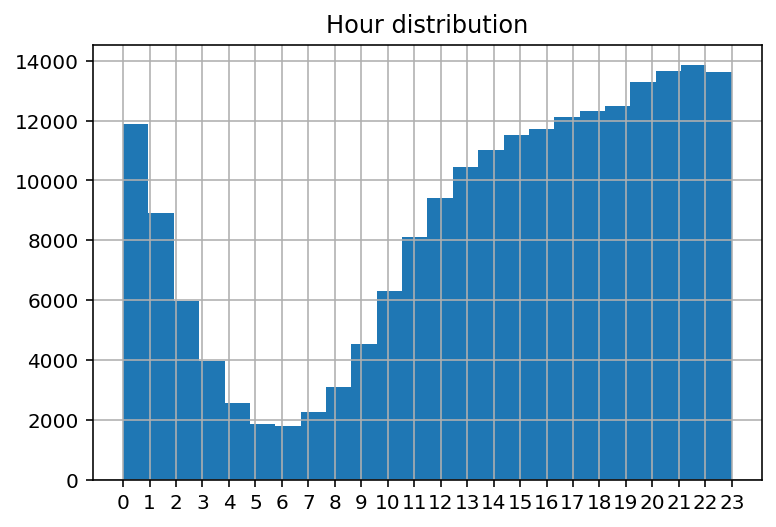

In [43]:
ax = reviews_df["datetime"].dt.hour.hist(bins=24)
ax.set_xticks(range(0, 24), minor=False)
ax.set(title="Hour distribution");

People tend to publish reviews the later the more often with absolute maximum around 20-23 o'clock in the evening and absolute minimum around 4-7 o'clock in the morning.

##### Weekday distribution

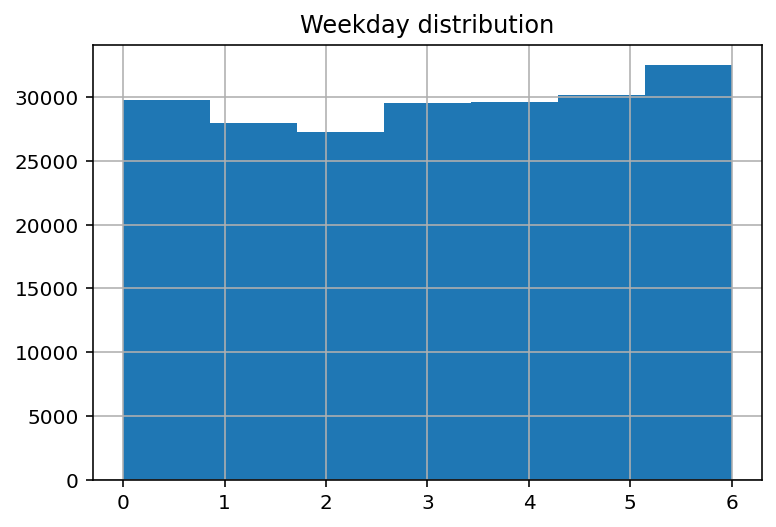

In [44]:
ax = reviews_df["datetime"].dt.weekday.hist(bins=7)
ax.set_xticks(range(0, 7), minor=False)
ax.set(title="Weekday distribution");

People tend to publish more reviews on Sundays, but between Mondays, Thursdays, Fridays and Saturdays the difference is not that significant

##### Month distribution

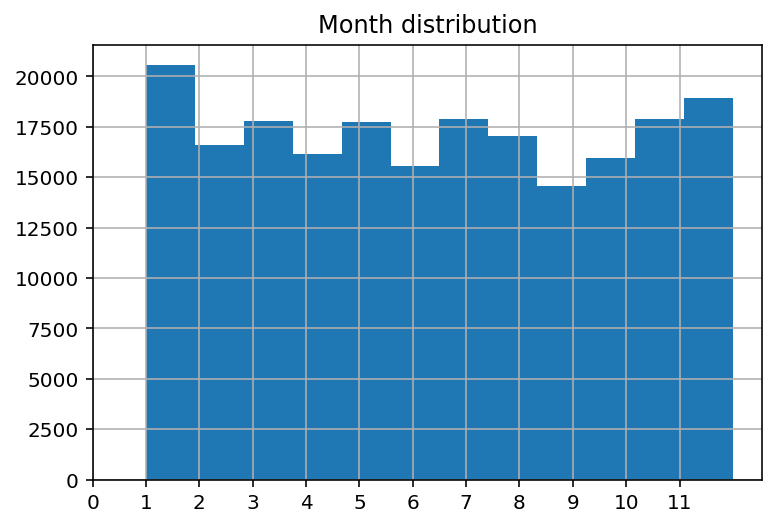

In [45]:
ax = reviews_df["datetime"].dt.month.hist(bins=12)
ax.set_xticks(range(0, 12), minor=False)
ax.set(title="Month distribution");

People tend to publish more reviews on winter months (especially on January). It can be caused by the number of holidays in Russia on January and, also, generally correlated with cold weather.

### `usefulness_ratio`

#### Transformation

Currently, `usefulness_ratio` looks like this:

In [46]:
reviews_df["usefulness_ratio"].sample(
    10,
)

77781     121 / 29
95631     103 / 28
79642      19 / 16
131067    44 / 120
122319       5 / 0
42927        6 / 1
28644       10 / 3
37893      19 / 14
39260      24 / 20
62718       9 / 22
Name: usefulness_ratio, dtype: object

We can replace `/` with `-` and then evaluate expression to get difference between likes and dislikes for the review. Let's do this.

In [47]:
reviews_df["usefulness"] = (
    reviews_df["usefulness_ratio"].replace(" / ", "-", regex=True).progress_apply(eval)
)

100%|██████████████████████████████████████████████████████████████████████| 206737/206737 [00:01<00:00, 203674.00it/s]


Now we can drop the `usefulness_ratio` column.

In [48]:
reviews_df.drop("usefulness_ratio", axis=1, inplace=True, errors="ignore")

#### Analysis

In [49]:
reviews_df["usefulness"].describe()

count    206737.000000
mean          3.836236
std          67.719842
min       -9332.000000
25%          -1.000000
50%           4.000000
75%          12.000000
max        4921.000000
Name: usefulness, dtype: float64

We have some pretty big outliers

In [50]:
usefulness = reviews_df["usefulness"]

In [51]:
usefulness.quantile(0.05), usefulness.quantile(0.95)

(-29.0, 41.0)

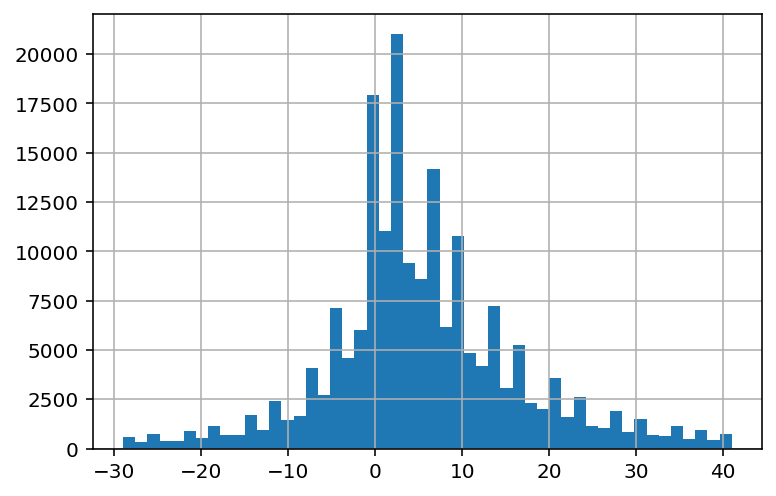

In [52]:
usefulness[
    (usefulness >= usefulness.quantile(0.05))
    & (usefulness <= usefulness.quantile(0.95))
].hist(bins=50);

### `review_body`

Some reviews have user's score in them. But scores located inside the review (usually, at the end of the review).  
Empirically, the next basic approach was developed. 

In [74]:
def return_score(preprocessor, review: str) -> str:
    scores = []
    score = ""
    for s in review.split("<p>")[-3:]:
        if preprocessor.has_numbers(s) and (("/" in s) or ("из" in s)):
            scores.append(s)

    score_candidate = (
        BeautifulSoup(scores[-1], "html.parser").get_text() if scores else ""
    )
    if scores and len(score_candidate.split(" ")) <= 4 and score_candidate != "":
        score = score_candidate
    return score.strip()

In [75]:
prep = preprocessor.Preprocessor()

In [77]:
scores = [return_score(prep, review) for review in reviews_df["review_body"].values]

C:\Users\ryblo\Documents\projects\movie_reviews\venv\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "http://www.agvaya.ru/?p=721#more-721" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\ryblo\Documents\projects\movie_reviews\venv\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "http://www.kinopoisk.ru/user/5016861/comment/2221734/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [78]:
reviews_df["scores"] = scores

In [84]:
counts = reviews_df["scores"].value_counts(ascending=True)

In [93]:
counts[counts == 1]

5,7 из 6                1
6.4 из 10               1
оценка: 10 из 10        1
Вообщем, 10 из 10       1
и 4 из 10               1
                       ..
10/10 однозначно.       1
10из 10.                1
бесконечность из 10     1
Оцениваю: 4 из 10       1
Оценка как кино 7/10    1
Name: scores, Length: 723, dtype: int64

TBD

## Saving merged and transformed dataset

In [95]:
reviews_df.to_parquet("../../data/mt_reviews.parquet")